# Preprocessing workflow

The purpose of this notebook is to show how to write a Nipype workflow to preprocess fMRI data from a single subject or a whole experiment. Nipype provides a common interface structure for various neuroimaging software packages and an intelligent way to handle execution of the various steps in the pipeline.

Utilizing nipype workflows has several advantages, such as utilizing parallel processing, cache-ing, handling inputs and outputs uniformly, and being able to visualize the entire workflow. For a detailed look at Nipype, see [the original article](https://mcgovern.mit.edu/wp-content/uploads/2019/01/fninf-05-00013-1.pdf), and look through [its documentation.](https://nipype.readthedocs.io/en/latest/)

In this workflow, we will be using FSL and ANTS but Nipype is also able to interface SPM, AFNI, FreeSurfer and many more neuroimaging software packages, provided you have them installed in your system. 

## Anatomical preprocessing

Prior to handling the functional data, we will preprocess the anatomical data to prepare for the functional to structural registration (i.e. co-registration) of the multiple BOLD runs for a subject.

Steps we will take are:

1. Bias field correction - ANTs' N4BiasFieldCorrection.
2. Skull-stripping - FSL's Brain Extraction Tool (BET).
3. Spatial normalization - ANTs' Affine and Diffeomorphic (SyN) Registration.

### Workflow and Nodes

Nipype's workflow engine allows concatenating the result of multiple operations and formally specifying the how preprocessing inputs and output should be connected. The individual operations are contained inside *nodes*.These can be the preprocessing algorithm to be be applied to the data or auxiliary interfaces or functions, such as those handling input and output of files.

Let's go ahead and initialize our workflow.

In [1]:
from nipype import MapNode, Node, Workflow, Function
import os

preproc_dir = os.getcwd()
wf = Workflow(name = 'preproc_wf', base_dir = preproc_dir)

#### Grabbing data
Now, we will declare the first couple of nodes to handle input of the data. We use two kinds of nodes: `IdentityInterface` and `DataGrabber`. An `IdentityInterface` node is the simplest node possible. The way it is used here allows the workflow to iterate through multiple subjects by leveraging the `iterables` property.

Note: `iterables` is not unique to `IdentityInterface` nodes. This property can be specified also in nodes created with Node or MapNode.

In [35]:
from nipype import IdentityInterface, DataGrabber, DataSink

subject_list = ['control01']

# A IdentityInterface node helps to iterate over list of subject ids
info_subj = Node(IdentityInterface(fields=['subject_id']), name="info_subj")
info_subj.iterables = [('subject_id', subject_list)]

##### Enabling iteration

To keep things simple (and my computer from crashing), I only run the first subject in this notebook. But the way this workflow is written, we can enable parallel processing of the whole dataset by feeding in a list subject ids in this step:

```python
subject_list = ['sub-01', 'sub-02',..., 'sub-39']
```
or whichever are your subject identifiers. In this data: 
```python 
subject_list = ['sub-control01', ..., 'sub-control20', 'sub-mdd01', ..., 'sub-mdd19']
```

Note: For parallel processing, we would also need to specify a special execution plug-in. But more on that later.

##### Grabbing file of current iteration
A `DataGrabber` node will produce paths to the files according to the strings you feed them. In combination with an iterable `IdentityInterface`, it will produce file paths for each element in the list of subject list. In this data, the different characteristics of anatomical and functional image directories —i.e., multiple runs BOLD runs but only one T1-weighted image per subject—will impact how we iterate through each. Therefore, we will need to write separate `Data Grabber` nodes for anatomical and functional files. 

Let's start by putting together the workflow for our T1-weighted images and we'll move on to functional images later in the notebook.

In [36]:
# DataGrabber 1 - grab_anat
data_dir = '/Users/vgonzenb/Python/nipy/fmri-rep/data/ds000171/'

grab_anat = Node(DataGrabber(infields=['subject_id'],outfields=['anat']), name = 'grab_anat')
grab_anat.inputs.base_directory = data_dir
grab_anat.inputs.template = '*'
grab_anat.inputs.sort_filelist = True
grab_anat.inputs.template_args = {'anat': [['subject_id']]} # A dictionary specifying orguments for each outfield
grab_anat.inputs.field_template = {'anat': 'sub-%s/anat/s*T1w.nii.gz'} # The string/file path that will be matched 
# Note the use of %s to indicate where the subject_id should be in the file path

Next, let's connect the nodes we have so far.

In [37]:
wf.connect(info_subj, 'subject_id', grab_anat, 'subject_id')

#### Bias Field Correction

Next, we will correct the intensity inhomogeneities in the T1-weighted images using the `N4BiasFieldCorrection` algorithm from ANTs. 

In [38]:
from nipype.interfaces.ants import N4BiasFieldCorrection

n4_biascorrect = Node(N4BiasFieldCorrection(), name='n4bias_correct')

n4_biascorrect.inputs.save_bias = True
n4_biascorrect.inputs.dimension = 3

Normally we would also specify:
```python
n4_biascorrect.inputs.output_image = 'output/ants-n4/anat_corrected.nii.gz'
n4_biascorrect.inputs.bias_image = 'output/ants-n4/anat_bias.nii.gz'
```

But the workflow engine handles input/output files in relation to preceding/subsequent nodes.

Also, learning the parameters for the [ANTs N4BiasFieldCorrection interface](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html#n4biasfieldcorrection), or any other interface for that matter, is easy given Nipype's well-kept documentation.

The arguments of `Workflow.connect` can be written as
```python
'node_of_output', 'the_out_file', 'node_of_input', 'the_in_file'
```
or a list of 3-tuples, each specifyng node-to-node relationship where the third element is a list of 2-tuples representing file-to-file relationships
```python
[('node_of_output_1', 'node_of_input_1', [('out_file_1', 'in_file_1'),
                                          ('out_file_2', 'in_file_2')])]
```
Here, we opt for the second way to remain consistent later when we declare multiple connections at once.

In [39]:
wf.connect([(grab_anat, n4_biascorrect, [('anat', 'input_image')])])

#### Brain Extraction

For skull-stripping, we will write a sub-workflow that 
1. runs FSL's BET on an image
2. calculates the center of mass for the resulting brain mask
3. re-runs BET on the original image with the center of mass from step 2.

Note that we define this workflow as a function. This will allow us to reuse the workflow without having to rewrite the nodes.

In [40]:
def init_improved_bet(name):
    """Recomputes a brain mask accounting for center of mass"""
    
    from nipype.interfaces.fsl import BET
    from scipy.ndimage.measurements import center_of_mass
    from nipype import Workflow, Node, Function, IdentityInterface 
    import nibabel
    
    improved_bet = Workflow(name = name)
    
    inputnode = Node(IdentityInterface(fields = ['image']), name = 'inputspec')
        
    bet = Node(BET(), name = 'bet_init')
    bet.inputs.frac = 0.5
    bet.inputs.mask = True
    bet.inputs.no_output = True # no output on first pass

    def get_cog(brain_mask):
        import nibabel as nib
        mask = nib.load(brain_mask).get_fdata()

        from scipy.ndimage.measurements import center_of_mass
        cog = [int(x) for x in list(center_of_mass(mask))]
        return(cog)

    center = Node(Function(function=get_cog, 
                               inputs_names='brain_mask', 
                               output_names='cog'), 
                      name = 'get_center')
    
    bet_cog  = Node(BET(), name='bet_improved')
    bet_cog.inputs.frac = 0.3 # Lenient boundarization 
    bet_cog.inputs.mask = True
    
    outputnode = Node(IdentityInterface(fields = ['brain', 'mask']), name = 'outputspec')
    
    improved_bet.connect([(inputnode, bet, [('image', 'in_file')]),
                          (bet, center, [('mask_file', 'brain_mask')]),
                          (center, bet_cog, [('cog', 'center')]),
                          (inputnode, bet_cog, [('image', 'in_file')]),
                          (bet_cog, outputnode, [('out_file', 'brain'),
                                                 ('mask_file', 'mask')])])
    return improved_bet

Now, we initialize one instance of this workflow for our anatomic preprocessing pipeline.

In [2]:
bet_anat_wf = init_improved_bet(name = "bet_anat_wf")

NameError: name 'init_improved_bet' is not defined

And we pass the N4 bias-corrected image directly onto the input node in this workflow. 

In [42]:
wf.connect([(n4_biascorrect, bet_anat_wf, [('output_image', 'inputspec.image')])])

Notice that when connecting nodes from a different workflow the following the syntax is a follows:

```python
[('node_of_output', 'workflow_of_input', [('out_file', 'node_name_in_workflow.in_file')])]
```

#### Spatial Normalization

We will register the bias-corrected, skull-stripped anatomical image to the MNI template using ANT's `Registration`. Let's go ahead and declare this node as a function since we will be re-using it for functional preprocessing.

Note: The parameters used in these example result in a quick (~5 mins) registration run time; these parameters are the default in John Muschelli's `extrants` R package. I have tried to add comments throughout based on my understanding from consulting the [ANTs documentation](https://github.com/ANTsX/ANTs/wiki/Anatomy-of-an-antsRegistration-call).

In [43]:
def init_registration_node(name):
    """Wraps an antsRegistration node to reuse same parameters"""
    from nipype.interfaces.ants import Registration
    from nipype import Node

    reg = Node(Registration(), name = name)
    
    # Choose the type of transforms, metrics and other general parameters
    reg.inputs.transforms = ['Affine', 'SyN']
    reg.inputs.write_composite_transform = True # join both Affine and Syn transforms into one
    reg.inputs.metric = ['Mattes', 'Mattes'] # Mutual Information metric
    reg.inputs.metric_weight = [1]*2
    reg.inputs.radius_or_number_of_bins = [32]*2 # bins for joint histograms
    reg.inputs.sampling_strategy = ['Regular', None]
    reg.inputs.sampling_percentage = [0.2, 1]
    reg.inputs.winsorize_lower_quantile = 0.005
    reg.inputs.winsorize_upper_quantile = 0.995

    # Parameters are (GradientStep, updateFieldVarianceInVoxelSpace, totalFieldVarianceInVoxelSpace)
    reg.inputs.transform_parameters = [(0.25,), (0.2, 3.0, 0.0)]

    # Implementing multiscale optimization: choose shrinking factors and kernel size per iteration 
    reg.inputs.number_of_iterations = [[2100,1200,1200,0],[40,20,0]]
    reg.inputs.smoothing_sigmas = [[3,2,1,0],[2,1,0]]       
    reg.inputs.shrink_factors = [[4, 2, 2, 1],[4, 2, 1]]

    # Other parameters
    reg.inputs.float = False
    reg.inputs.dimension = 3
    
    return reg

The MNI template that is included with FSL can be accessed via nipype as well.

In [44]:
from nipype.interfaces.fsl import Info
template_path = Info.standard_image('MNI152_T1_1mm_brain.nii.gz')

Now, we initialize the node. And because we want to normalize the anatomical image, we set the `ref_image` to the MNI template. 

In [45]:
reg_anat2template = init_registration_node(name = "reg_anat2template")
reg_anat2template.inputs.fixed_image = template_path

wf.connect([(bet_anat_wf, reg_anat2template, [('outputspec.brain', 'moving_image')])])

Lastly, because of antsRegistration returns only a transformation matrix and not the image, we will need an `ApplyTransform` node to produce the normalized anatomical image. 

In [46]:
from nipype.interfaces.ants import ApplyTransforms

transf_anat = Node(ApplyTransforms(), name = 'transform_anat')
transf_anat.inputs.reference_image = template_path
transf_anat.inputs.dimension = 3
transf_anat.inputs.interpolation = 'LanczosWindowedSinc'

wf.connect([(reg_anat2template, transf_anat, [('composite_transform',  'transforms')]),
            (bet_anat_wf, transf_anat, [('outputspec.brain', 'input_image')])])

#### Saving outputs

Nipype provides `DataSink` to easily create subfolders and store the results.

In [47]:
from nipype.interfaces.io import DataSink

datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = os.path.join(os.getcwd(), "data")
datasink.inputs.substitutions = [('_subject_id_', 'sub-')]

wf.connect([(info_subj, datasink, [('subject_id', 'container')]),
            (n4_biascorrect, datasink, [('output_image', 'anat.N4')]),
            (bet_anat_wf, datasink, [('outputspec.brain', 'anat.bet.@brain'),
                                     ('outputspec.mask', 'anat.bet.@mask')]),
            (reg_anat2template, datasink, [('composite_transform', 'anat.reg.@transform')]),
            (transf_anat, datasink, [('output_image', 'anat.reg.@func_in_template_space')])])

#### Graph Visualization

Now that we have the anatomical preprocessing part of the workflow, let's visualize it. Since we are using nipype, we can visualize the dataflow between our interfaces easily.

200717-19:00:02,29 nipype.workflow INFO:
	 Generated workflow graph: /Users/vgonzenb/Python/nipy/fmri-rep/preproc/preproc_wf/anat_workflow_detailed.png (graph2use=exec, simple_form=False).


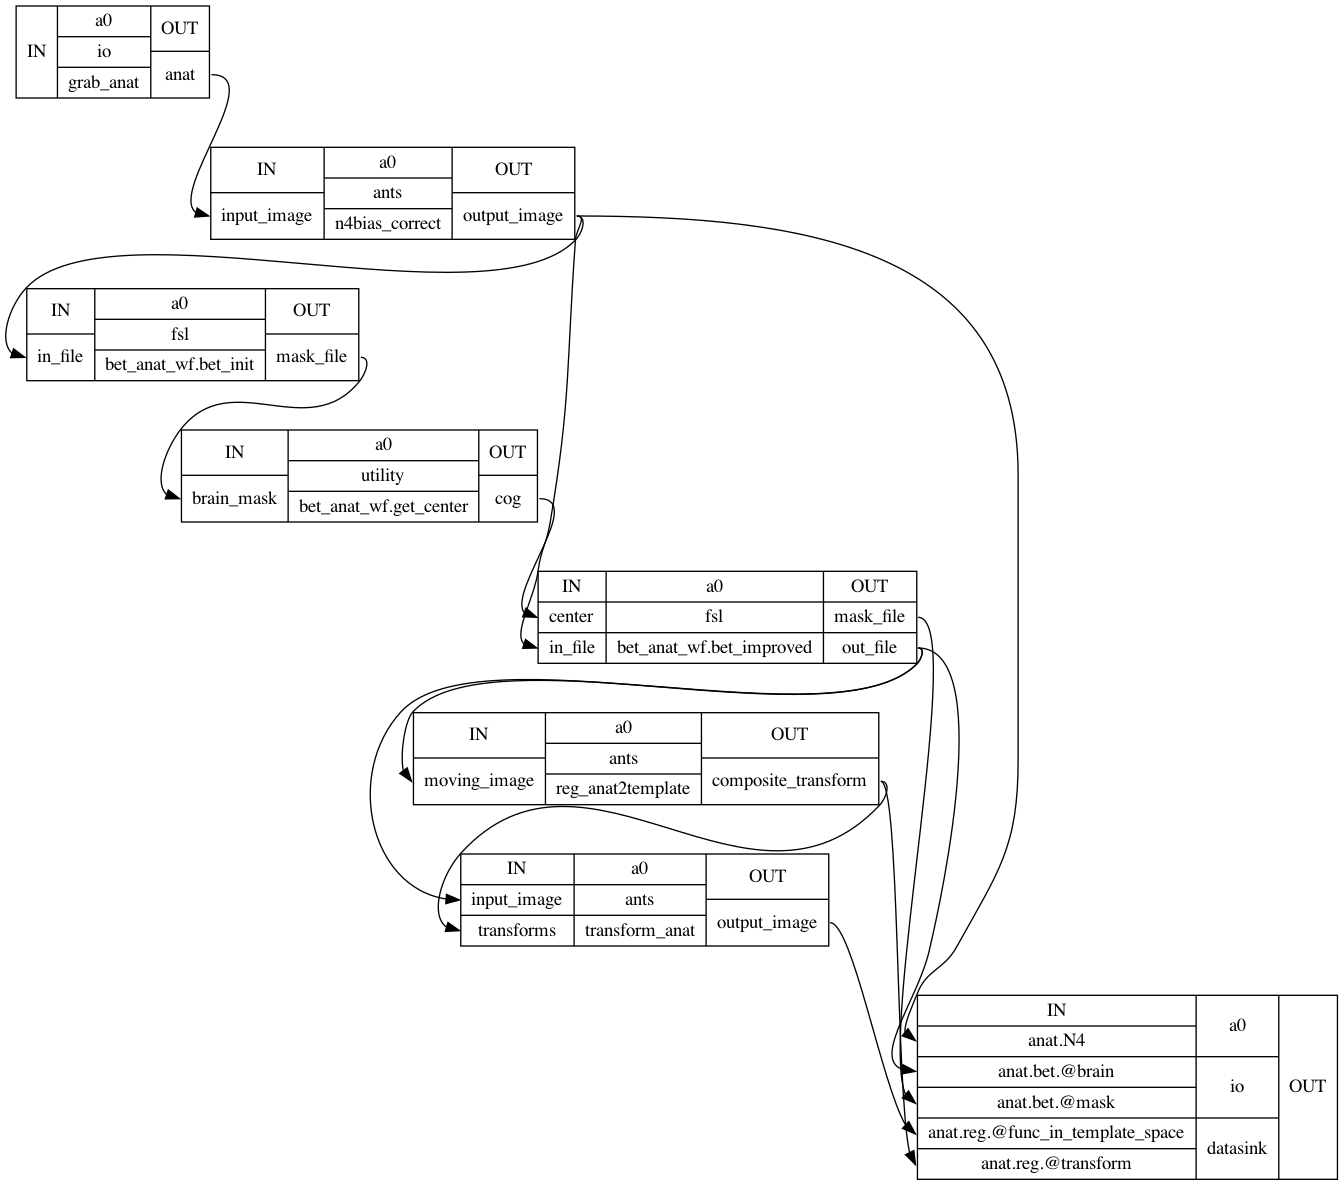

In [48]:
wf.write_graph(dotfilename = 'anat_workflow.dot', graph2use = 'exec', simple_form = False)

# Visualize graph
from IPython.display import Image
Image(filename="preproc_wf/anat_workflow_detailed.png")

## Functional preprocessing

Now that we tackled anatomical preprocessing, we can start to build the part of the workflow that will handle the BOLD runs. To be clear, when running, the workflow does not have wait for all the anatomical preprocessing steps to be completed before starting to operate on the functional images. In this notebook, these two parts of the workflow are presented separately only for conceptual clarity.

The preprocessing steps and tools we will use are the following:

1. Slice timing correction - FSL's SliceTimer
2. Motion Correction - FSL's MCFLIRT
3. Calculate a brain mask - FSL's BET subworkflow
4. Coregistration to anatomical space - ANTs Registration
5. Spatial normalization - ANT's ApplyTransform function 

### Grab data

We need to write a data grabber for the functional images but also an iterator node for the different runs. 

In [49]:
runs = [1]

# A IdentityInterface node helps to iterate over list of subject ids
info_run = Node(IdentityInterface(fields=['run_id']), name="info_run")
info_run.iterables = [('run_id', runs)]

# DataGrabber 2 - func
grab_func = Node(DataGrabber(infields=['subject_id', 'runs'],outfields=['func']), name = 'grab_func', nested = True)
grab_func.inputs.base_directory = data_dir
grab_func.inputs.template = '*'
grab_func.inputs.sort_filelist = True
grab_func.inputs.template_args = {'func': [['subject_id', 'runs']]}
grab_func.inputs.field_template = {'func': 'sub-%s/func/sub-*run-%d_bold.nii.gz'}

In [50]:
# Connect nodes
wf.connect([(info_subj, grab_func, [('subject_id', 'subject_id')]),
            (info_run, grab_func, [('run_id', 'runs')])])

### Slice Timing Correction

Because TR = 3s slice timing correction is performed first.

In [51]:
from nipype.interfaces.fsl import SliceTimer

slice_t = Node(SliceTimer(), name = 'slice_timer') 
slice_t.inputs.interleaved = True
slice_t.inputs.time_repetition = 3

wf.connect([(grab_func, slice_t, [('func', 'in_file')]),
            (slice_t, datasink, [('slice_time_corrected_file', 'func.slice_t')])])

### Motion Correction

In [52]:
from nipype.interfaces.fsl import MCFLIRT

m_corr = Node(MCFLIRT(), name = 'm_corr')

m_corr.inputs.cost = 'mutualinfo'
m_corr.inputs.interpolation = 'sinc'
m_corr.inputs.mean_vol = True # output a mean of time series
m_corr.inputs.save_mats = True
m_corr.inputs.save_plots = True

wf.connect([(slice_t, m_corr, [('slice_time_corrected_file', 'in_file')]),
            (m_corr, datasink, [('out_file', 'func.m_corr')])])

### Brain Extraction

To create a brain mask for the functional runs we can re-use our improved BET workflow from earlier. Another reason why Nipype is great! Over time we can define multiple small workflows that others can mix and match with relative simplicity.

In [53]:
bet_func_wf = init_improved_bet(name = "bet_func_wf")

wf.connect([(m_corr, bet_func_wf, [('mean_img', 'inputspec.image')]),
            (bet_func_wf, datasink, [('outputspec.brain', 'func.bet.@brain'),
                                      ('outputspec.mask', 'func.bet.@mask')])])

### From coregistration to normalization

In this step, we will calculate a set of transforms that take each BOLD run to standard space.
First, we'll register the BOLD runs to anatomical space. We can do this by using the same `init_registration_node` function from above. 

In [54]:
reg_func2anat = init_registration_node(name = "reg_func2anat")
wf.connect([(bet_func_wf, reg_func2anat, [('outputspec.brain', 'moving_image')]),
            (transf_anat, reg_func2anat, [('output_image', 'fixed_image')])])

Now that the functional and anatomical images will be in the same space, we can use the same anatomical transformation (from earlier) on the functional images and this will bring them to standard space. 

There's a key intermediate step that we can't ignore: we need to combine the two transforms into one. The reason is that applying the transforms in one go will reduce the amount of interpolation from resampling the image.

We can combine two transform files with ANTs' `ComposeMultiTransform`. 
This function takes a list of transforms, so we need a simple node that will take the transforms and return them in list format.

In [55]:
def list_transforms(transform1, transform2):
    return [transform1, transform2]

transform_list = Node(Function(input_names = ['transform1', 'transform2'],
                               output_names = 'list_of_transforms',
                              function = list_transforms),
                     name = "transform_list")

# Note composite_transform  is output of registration nodes, i.e. Affine + Syn transforms
wf.connect([(reg_anat2template, transform_list, [('composite_transform', 'transform1')]),
            (reg_func2anat, transform_list, [('composite_transform', 'transform2')])])

Then, we pass the list of transforms to `ComposeMultiTransform`.

In [56]:
from nipype.interfaces.ants import ComposeMultiTransform

compose_transf = Node(ComposeMultiTransform(), name = 'compose_transform')
compose_transf.inputs.dimension = 3

wf.connect([(transform_list, compose_transf, [('list_of_transforms', 'transforms')])])

Finally, we apply the composite transform to the BOLD run with `antsApplyTransforms`. We specify a mask and `dimension = 4` to be able to apply the transform to all (motion-corrected) volumes in the run.

In [ ]:
transf_func = Node(ApplyTransforms(), name = 'transform_func')
transf_func.inputs.reference_image = template_path
transf_func.inputs.dimension = 4
transf_func.inputs.interpolation = 'LanczosWindowedSinc'

wf.connect([(compose_transf, transf_func, [('output_transform',  'transforms')]),
            (bet_func_wf, transf_func, [('outputspec.brain', 'input_image')]),
            (transf_func, datasink, [('output_image', 'reg.@func_in_template_space')])])

### Visualizing the final graph


In [ ]:
wf.write_graph(dotfilename = 'func_workflow.dot', graph2use = 'orig', simple_form = False)

# Visualize graph
from IPython.display import Image
Image(filename="preproc_wf/func_workflow_detailed.png")

## Executing the workflow

Now that all steps are taken care of we can easily run this workflow:

In [ ]:
wf.run()